# Used in this kernel:
* preprocessed dataset by olivier https://www.kaggle.com/ogrellier/create-extracted-json-fields-dataset
* exported google analytics data https://www.kaggle.com/satian/exported-google-analytics-data


* story of a leak v.01 https://www.kaggle.com/igauty/story-of-a-leak-v01
* future is here https://www.kaggle.com/ashishpatel26/future-is-here
* teach-lightgbm-to-sum-predictions https://www.kaggle.com/satian/story-of-a-leak/notebook


The code below is full of bugs, which I didn't remove as they seem to improve LB.

In [1]:
import pandas as pd
import numpy as np

# DRAGONS
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

# plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# pandas / plt options
pd.options.display.max_columns = 999
plt.rcParams['figure.figsize'] = (14, 7)
font = {'family' : 'verdana',
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)

# remove warnings
import warnings
warnings.simplefilter("ignore")

# garbage collector
import gc
gc.enable()
from sklearn.model_selection import GridSearchCV
from  sklearn.preprocessing import LabelEncoder

/Users/Rick/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Loading data

In [2]:
# train = pd.read_csv('./all/extracted_fields_train.gz', dtype={'date': str, 'fullVisitorId': str, 'sessionId':str, 'visitId': np.int64})
# test = pd.read_csv('./all/extracted_fields_test.gz', dtype={'date': str, 'fullVisitorId': str, 'sessionId':str, 'visitId': np.int64})
# train.shape, test.shape
# test['fullVisitorId'].nunique()

In [3]:
# Loading data v2
train = pd.read_csv('./all/v2/extracted_fields_train_v2.gz', dtype={'date': str, 'fullVisitorId': str, 'sessionId':str, 'visitId': np.int64})
test = pd.read_csv('./all/v2/extracted_fields_test_v2.gz', dtype={'date': str, 'fullVisitorId': str, 'sessionId':str, 'visitId': np.int64})
train.shape, test.shape

((1708337, 29), (401589, 29))

In [4]:
sample = pd.read_csv('./all/v2/sample_submission_v2.csv.zip')

In [5]:
# Cleaning Revenue
for df in [train, test]:
    df["totals.transactionRevenue"] =  df["totals.transactionRevenue"].astype(str)
    df["totals.transactionRevenue"].fillna('$', inplace=True)
    df["totals.transactionRevenue"] = df["totals.transactionRevenue"].apply(lambda x: x.replace('$', '').replace(',', ''))
    df["totals.transactionRevenue"] = pd.to_numeric(df["totals.transactionRevenue"], errors="coerce")
    df["totals.transactionRevenue"].fillna(0.0, inplace=True)

# Looking around

Some pictures to have in mind: target distribution

In [6]:
target_sums = train.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

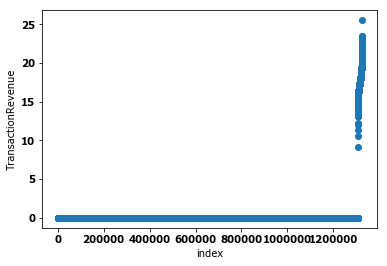

In [7]:
plt.scatter(range(target_sums.shape[0]), np.sort(np.log1p(target_sums["totals.transactionRevenue"].values)))
plt.xlabel('index')
plt.ylabel('TransactionRevenue')
plt.show()

Key problem:

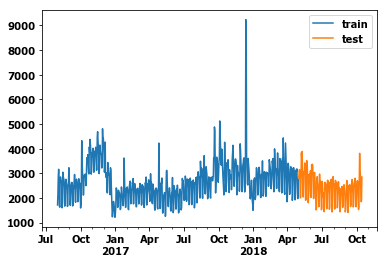

In [8]:
train.date = pd.to_datetime(train.date, format="%Y%m%d")
test.date = pd.to_datetime(test.date, format="%Y%m%d")
train.date.value_counts().sort_index().plot(label="train")
test.date.value_counts().sort_index().plot(label="test")
plt.legend()

Comparing categories in train and test:

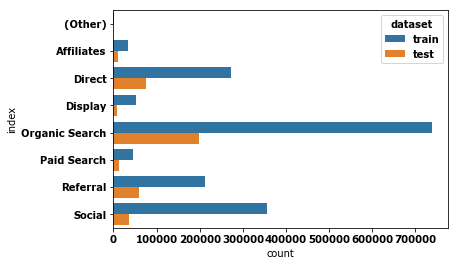

In [9]:
def drawBars(columnname):
    sns.barplot(x="count", y="index", hue="dataset",
        data=pd.melt(pd.concat([train[columnname].value_counts().rename("train"), 
                       test[columnname].value_counts().rename("test")], axis=1, sort="False").reset_index(),
            id_vars="index", var_name="dataset", value_name="count"))

drawBars("channelGrouping")

In [10]:
# d = pd.concat([train['channelGrouping'].value_counts().rename("train"), 
#                        test['channelGrouping'].value_counts().rename("test")], axis=1, sort="False").reset_index()
# pd.melt(d,id_vars="index", var_name="dataset", value_name="count")

In [11]:
# import pandas as pd
# df = pd.DataFrame({'A': {0: 'a', 1: 'b', 2: 'c'},
#                     'B': {0: 1, 1: 3, 2: 5},
#                     'C': {0: 2, 1: 4, 2: 6}})
# pd.melt(df, id_vars=['A'],var_name ='dateset',value_name = "count")

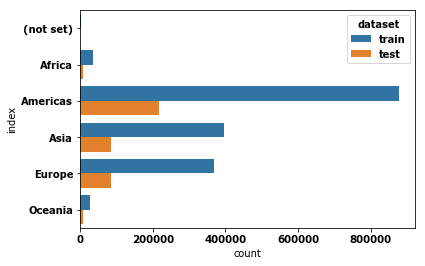

In [12]:
drawBars("geoNetwork.continent")

In [13]:
ids_train = set(train.fullVisitorId.unique())
ids_test = set(test.fullVisitorId.unique())
print("Unique visitor ids in train:", len(ids_train))
print("Unique visitor ids in test:", len(ids_test))
print("Common visitors in train and test:", len(ids_train & ids_test))

Unique visitor ids in train: 1323730
Unique visitor ids in test: 296530
Common visitors in train and test: 2759


In [14]:
train  = train[train.fullVisitorId.isin(ids_test)]
train = pd.concat([train,test])

In [15]:
print("Train: ", np.bincount(train.visitStartTime.value_counts()))


Train:  [     0 401814   7067    301     56     15      6      5      0      1]


In [16]:
print("test: ", np.bincount(test.visitId.value_counts()))

test:  [     0 385311   7470    312     59     16      7      5      0      1]


# Preprocessing

Setting time as index and saving time as feature (for FE purposes only)

In [17]:
train.visitStartTime = pd.to_datetime(train.visitStartTime, unit='s')
test.visitStartTime = pd.to_datetime(test.visitStartTime, unit='s')
train["date"] = train.visitStartTime
test["date"] = test.visitStartTime

In [18]:
# train.set_index("visitStartTime", inplace=True)
# test.set_index("visitStartTime", inplace=True)
# train.sort_index(inplace=True)
# test.sort_index(inplace=True)
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417230 entries, 13 to 401588
Data columns (total 29 columns):
channelGrouping               417230 non-null object
date                          417230 non-null datetime64[ns]
fullVisitorId                 417230 non-null object
visitId                       417230 non-null int64
visitNumber                   417230 non-null float64
visitStartTime                417230 non-null datetime64[ns]
device.browser                417230 non-null object
device.deviceCategory         417230 non-null object
device.isMobile               417230 non-null float64
device.operatingSystem        417230 non-null object
geoNetwork.city               417230 non-null object
geoNetwork.continent          417230 non-null object
geoNetwork.country            417230 non-null object
geoNetwork.metro              417230 non-null object
geoNetwork.networkDomain      417230 non-null object
geoNetwork.region             417230 non-null object
geoNetwork.subContinent

# Features

Basic time features:

In [20]:
for df in [train, test]:
    df['weekday'] = df['date'].dt.dayofweek.astype(object)
    df['time'] = df['date'].dt.second + df['date'].dt.minute*60 + df['date'].dt.hour*3600
    df['month'] = df['date'].dt.month   # it must not be included in features during learning!
    df['day'] = df['date'].dt.date       # it must not be included in features during learning!
    df['year'] = df['date'].dt.year

In [21]:
print(train['day'].min(),train['day'].max())
print(test['day'].min(),test['day'].max())

2016-08-01 2018-10-16
2018-05-01 2018-10-16


In [22]:
# Target Lags
def lag_features(df,lags,col,isdel = True):
    tmp  = df[['fullVisitorId','date',col]]
    for i in lags:
        shifted = tmp.copy()
        if i == 1:
            days = 46
        else:
            days = 30 * (i - 1) + 46
        shifted['date'] = shifted['date'] + pd.Timedelta(days = days)
        shifted['year'] = shifted['date'].dt.year
        shifted['month'] = shifted['date'].dt.month
        shifted.drop(['date'],axis = 1,inplace= True)
        shifted.columns = ['fullVisitorId',col + '_lag_' + str(i),'year','month']
        print("shape ",shifted.shape)
        df = pd.merge(df,shifted,on = ['fullVisitorId','year','month'],how = 'left')
        df[col + '_lag_' + str(i)].fillna(0,inplace = True)
        del shifted
        gc.collect()
    if isdel:   
        df.drop([col],axis = 1,inplace = True)    
    return df


In [23]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296530 entries, 0 to 296529
Data columns (total 2 columns):
fullVisitorId          296530 non-null object
PredictedLogRevenue    296530 non-null float64
dtypes: float64(1), object(1)
memory usage: 4.5+ MB


In [24]:
test1 = sample[['fullVisitorId']].copy()
test2 = sample[['fullVisitorId']].copy()
test1['year'] = 2018
test1['month'] = 12
test1['date'] =  test1['year'].astype(str) + "-" + test1['month'].astype(str) + "-" + "20"

test2['year'] = 2019
test2['month'] = 1
test2['date'] =  test2['year'].astype(str) + "-" + test2['month'].astype(str) + "-" + "20"
test = pd.concat([test1,test2])
test['date'] = pd.to_datetime(test['date'])
test['revenue_sum_month'] = 0.0

In [25]:
test.sample(10)

,fullVisitorId,year,month,date,revenue_sum_month
120202,4050980837982036485,2019,1,2019-01-20,0.0
199596,6736172178276739898,2018,12,2018-12-20,0.0
19815,0670255006189895763,2018,12,2018-12-20,0.0
199849,6743720097062818096,2018,12,2018-12-20,0.0
174008,5867205244190253380,2019,1,2019-01-20,0.0
64734,2179809617997165106,2019,1,2019-01-20,0.0
107430,3620751184340687215,2018,12,2018-12-20,0.0
274485,9257716644602055365,2019,1,2019-01-20,0.0
45921,154761953142111076,2018,12,2018-12-20,0.0
173868,5862713304535988097,2018,12,2018-12-20,0.0


In [26]:
cols = ['fullVisitorId','year','month']
data = train.groupby(by = cols).agg({'totals.transactionRevenue' : 'sum'}).reset_index().rename(columns = {'totals.transactionRevenue': 'revenue_sum_month'})
data['date'] =  data['year'].astype(str) + "-" + data['month'].astype(str) + "-" + "20"
data['date'] = pd.to_datetime(data['date'])
data['day'] = data['date'].dt.day
train_len = data.shape[0]
print("trai_len",train_len)
data = pd.concat([data,test])   

trai_len 321527


In [27]:
# visits

# step 1
data = lag_features(data,[1,2],'revenue_sum_month',False)

# step 2
sum_hits_month = train.groupby(by = cols).agg({'totals.hits' : 'sum'}).reset_index().rename(columns = {'totals.hits': 'hits_sum_month'})
data = data.merge(sum_hits_month,on = cols,how = 'left')
data = lag_features(data,[1,2],'hits_sum_month')

# # step 3
pageviews_sum_month = train.groupby(by = cols).agg({'totals.pageviews' : 'sum'}).reset_index().rename(columns = {'totals.pageviews': 'pageviews_sum_month'})
data = data.merge(pageviews_sum_month,on = cols,how = 'left')
data = lag_features(data,[1,2],'pageviews_sum_month')

# step 4
visits_sum_month = train.groupby(by = cols).size().reset_index(name = 'visits_sum_month')
data = data.merge(visits_sum_month,on = cols,how = 'left')
data = lag_features(data,[1,2],'visits_sum_month')

# step 5
payvisits_sum_month = train[train['totals.transactionRevenue'] > 0].groupby(by = cols).size().reset_index(name='payvisits_sum_month')
data = data.merge(payvisits_sum_month,on = cols,how = 'left')
data = lag_features(data,[1,2],'payvisits_sum_month')

# category labelencoder
le = LabelEncoder()
le.fit(data['fullVisitorId'].astype(str))
data['fullVisitorId'] = le.transform(data['fullVisitorId'].astype(str))

shape  (914587, 4)
shape  (914587, 4)
shape  (914587, 4)
shape  (914587, 4)
shape  (914587, 4)
shape  (914587, 4)
shape  (914587, 4)
shape  (914587, 4)
shape  (914587, 4)
shape  (914587, 4)


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 914587 entries, 0 to 914586
Data columns (total 16 columns):
date                         914587 non-null datetime64[ns]
day                          321527 non-null float64
fullVisitorId                914587 non-null int64
month                        914587 non-null int64
revenue_sum_month            914587 non-null float64
year                         914587 non-null int64
revenue_sum_month_lag_1      914587 non-null float64
revenue_sum_month_lag_2      914587 non-null float64
hits_sum_month_lag_1         914587 non-null float64
hits_sum_month_lag_2         914587 non-null float64
pageviews_sum_month_lag_1    914587 non-null float64
pageviews_sum_month_lag_2    914587 non-null float64
visits_sum_month_lag_1       914587 non-null float64
visits_sum_month_lag_2       914587 non-null float64
payvisits_sum_month_lag_1    914587 non-null float64
payvisits_sum_month_lag_2    914587 non-null float64
dtypes: datetime64[ns](1), float64(12), 

In [29]:
exclued_cols = ['date','day']
included_cols = [col for col in data.columns if col not in exclued_cols]
train_cols = [col for col in included_cols if col not in ['revenue_sum_month']]
train = data[included_cols].iloc[:train_len]
test = data[included_cols].iloc[train_len:]

validation = train[train.month >= 9]
train = train[train.month < 9]

print("train shape",train.shape)
print("validation shape",validation.shape)

train_X = train[train_cols]
train_y = np.log1p(train['revenue_sum_month'])

validation_X = validation[train_cols]
validation_y = np.log1p(validation['revenue_sum_month'])

test_X = test[train_cols]


train shape (237585, 14)
validation shape (83942, 14)


Looking to future features (from https://www.kaggle.com/ashishpatel26/future-is-here):

In [30]:
# df = pd.concat([train, test])
# df.sort_values(['fullVisitorId', 'date'], ascending=True, inplace=True)
# df['prev_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)).astype(np.int64) // 1e9 // 60 // 60
# df['next_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)).astype(np.int64) // 1e9 // 60 // 60

# df['prev_session_1'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(2)).astype(np.int64) // 1e9 // 60 // 60
# df['next_session_1'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-2)).astype(np.int64) // 1e9 // 60 // 60

# df.sort_index(inplace=True)

# train = df[:len(train)]
# test = df[len(train):]

User-aggregating features:

# Preparing validation

In [31]:
from sklearn.metrics import mean_squared_error
def score(data, y):
    validation_res = pd.DataFrame(
    {"fullVisitorId": data["fullVisitorId"].values,
     "transactionRevenue": data["totals.transactionRevenue"].values,
     "predictedRevenue": np.expm1(y)})

    validation_res = validation_res.groupby("fullVisitorId")["transactionRevenue", "predictedRevenue"].sum().reset_index()
    return np.sqrt(mean_squared_error(np.log1p(validation_res["transactionRevenue"].values), 
                                     np.log1p(validation_res["predictedRevenue"].values)))

Cute function to validate and prepare stacking

In [36]:
lgbmodel = lgb.LGBMRegressor(n_estimators=2000, objective="regression", metric="rmse",bagging_frequency=5, early_stopping_rounds = 1000,
                      bagging_seed=2019, use_best_model=True,bagging_fraction = 0.9,feature_fraction= 0.7,min_child_samples = 150,num_leaves = 31,learning_rate=0.03)
lgbmodel.fit(train_X,train_y,eval_set = [(validation_X,validation_y)])
lgbmodel_predicted = lgbmodel.predict(test_X)

[1]	valid_0's rmse: 2.23788
Training until validation scores don't improve for 1000 rounds.
[2]	valid_0's rmse: 2.23702
[3]	valid_0's rmse: 2.23646
[4]	valid_0's rmse: 2.23601
[5]	valid_0's rmse: 2.2353
[6]	valid_0's rmse: 2.23487
[7]	valid_0's rmse: 2.23421
[8]	valid_0's rmse: 2.23367
[9]	valid_0's rmse: 2.23312
[10]	valid_0's rmse: 2.23261
[11]	valid_0's rmse: 2.23215
[12]	valid_0's rmse: 2.23172
[13]	valid_0's rmse: 2.23137
[14]	valid_0's rmse: 2.23102
[15]	valid_0's rmse: 2.23072
[16]	valid_0's rmse: 2.23042
[17]	valid_0's rmse: 2.23017
[18]	valid_0's rmse: 2.22994
[19]	valid_0's rmse: 2.22972
[20]	valid_0's rmse: 2.22953
[21]	valid_0's rmse: 2.22935
[22]	valid_0's rmse: 2.22917
[23]	valid_0's rmse: 2.22902
[24]	valid_0's rmse: 2.22889
[25]	valid_0's rmse: 2.22876
[26]	valid_0's rmse: 2.22867
[27]	valid_0's rmse: 2.22858
[28]	valid_0's rmse: 2.22852
[29]	valid_0's rmse: 2.22843
[30]	valid_0's rmse: 2.22839
[31]	valid_0's rmse: 2.22836
[32]	valid_0's rmse: 2.22833
[33]	valid_0's rms

[280]	valid_0's rmse: 2.23416
[281]	valid_0's rmse: 2.23419
[282]	valid_0's rmse: 2.2342
[283]	valid_0's rmse: 2.2342
[284]	valid_0's rmse: 2.23419
[285]	valid_0's rmse: 2.23417
[286]	valid_0's rmse: 2.23416
[287]	valid_0's rmse: 2.23415
[288]	valid_0's rmse: 2.23416
[289]	valid_0's rmse: 2.23417
[290]	valid_0's rmse: 2.23415
[291]	valid_0's rmse: 2.23414
[292]	valid_0's rmse: 2.23417
[293]	valid_0's rmse: 2.23417
[294]	valid_0's rmse: 2.23417
[295]	valid_0's rmse: 2.23416
[296]	valid_0's rmse: 2.23416
[297]	valid_0's rmse: 2.23416
[298]	valid_0's rmse: 2.2342
[299]	valid_0's rmse: 2.2342
[300]	valid_0's rmse: 2.23422
[301]	valid_0's rmse: 2.23421
[302]	valid_0's rmse: 2.23421
[303]	valid_0's rmse: 2.23422
[304]	valid_0's rmse: 2.23421
[305]	valid_0's rmse: 2.2342
[306]	valid_0's rmse: 2.23421
[307]	valid_0's rmse: 2.2342
[308]	valid_0's rmse: 2.2342
[309]	valid_0's rmse: 2.23421
[310]	valid_0's rmse: 2.2342
[311]	valid_0's rmse: 2.23422
[312]	valid_0's rmse: 2.23422
[313]	valid_0's rm

[561]	valid_0's rmse: 2.23622
[562]	valid_0's rmse: 2.23621
[563]	valid_0's rmse: 2.23622
[564]	valid_0's rmse: 2.23623
[565]	valid_0's rmse: 2.23623
[566]	valid_0's rmse: 2.23624
[567]	valid_0's rmse: 2.23625
[568]	valid_0's rmse: 2.23625
[569]	valid_0's rmse: 2.23627
[570]	valid_0's rmse: 2.23629
[571]	valid_0's rmse: 2.23627
[572]	valid_0's rmse: 2.23627
[573]	valid_0's rmse: 2.23628
[574]	valid_0's rmse: 2.23628
[575]	valid_0's rmse: 2.23628
[576]	valid_0's rmse: 2.23626
[577]	valid_0's rmse: 2.23629
[578]	valid_0's rmse: 2.23631
[579]	valid_0's rmse: 2.23634
[580]	valid_0's rmse: 2.23635
[581]	valid_0's rmse: 2.23636
[582]	valid_0's rmse: 2.23636
[583]	valid_0's rmse: 2.23636
[584]	valid_0's rmse: 2.23637
[585]	valid_0's rmse: 2.23639
[586]	valid_0's rmse: 2.23645
[587]	valid_0's rmse: 2.23646
[588]	valid_0's rmse: 2.23647
[589]	valid_0's rmse: 2.23647
[590]	valid_0's rmse: 2.23648
[591]	valid_0's rmse: 2.23649
[592]	valid_0's rmse: 2.23651
[593]	valid_0's rmse: 2.23655
[594]	vali

[846]	valid_0's rmse: 2.23783
[847]	valid_0's rmse: 2.23783
[848]	valid_0's rmse: 2.23783
[849]	valid_0's rmse: 2.23783
[850]	valid_0's rmse: 2.23784
[851]	valid_0's rmse: 2.23785
[852]	valid_0's rmse: 2.23786
[853]	valid_0's rmse: 2.23787
[854]	valid_0's rmse: 2.23788
[855]	valid_0's rmse: 2.2379
[856]	valid_0's rmse: 2.2379
[857]	valid_0's rmse: 2.2379
[858]	valid_0's rmse: 2.23789
[859]	valid_0's rmse: 2.23792
[860]	valid_0's rmse: 2.23792
[861]	valid_0's rmse: 2.23793
[862]	valid_0's rmse: 2.23793
[863]	valid_0's rmse: 2.23794
[864]	valid_0's rmse: 2.23793
[865]	valid_0's rmse: 2.23794
[866]	valid_0's rmse: 2.23793
[867]	valid_0's rmse: 2.23793
[868]	valid_0's rmse: 2.23793
[869]	valid_0's rmse: 2.23793
[870]	valid_0's rmse: 2.23793
[871]	valid_0's rmse: 2.23793
[872]	valid_0's rmse: 2.23792
[873]	valid_0's rmse: 2.23792
[874]	valid_0's rmse: 2.23794
[875]	valid_0's rmse: 2.23793
[876]	valid_0's rmse: 2.23793
[877]	valid_0's rmse: 2.23794
[878]	valid_0's rmse: 2.23795
[879]	valid_0

# Meta-models

In [33]:
xgbmodel = xgb.XGBRegressor(max_depth=22, learning_rate=0.02, n_estimators=1000, 
                                         objective='reg:linear', gamma=1.45, seed=2019, silent=False,
                                        subsample=0.67, colsample_bytree=0.054, colsample_bylevel=0.50)
xgbmodel.fit(train_X,train_y,eval_set = [(validation_X,validation_y)])
xgbmodel_predicted = xgbmodel.predict(test_X)

[17:50:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=7
[0]	validation_0-rmse:2.24825
[17:50:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[1]	validation_0-rmse:2.2479
[17:50:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=11
[2]	validation_0-rmse:2.24734
[17:50:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[3]	validation_0-rmse:2.24688
[17:50:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 976 extra nodes, 2 pruned nodes, max_depth=22
[4]	validation_0-rmse:2.24629
[17:50:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[5]	validation_0-rmse:2.24586
[17:50:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2576 extra nodes, 2 pruned nodes, max_depth=22
[6]	validation_0-rmse:2.24509
[17

[17:50:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 24 pruned nodes, max_depth=17
[57]	validation_0-rmse:2.2316
[17:50:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 2 pruned nodes, max_depth=15
[58]	validation_0-rmse:2.23156
[17:50:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 12 pruned nodes, max_depth=15
[59]	validation_0-rmse:2.2315
[17:50:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 22 pruned nodes, max_depth=12
[60]	validation_0-rmse:2.23136
[17:50:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 22 pruned nodes, max_depth=16
[61]	validation_0-rmse:2.23122
[17:50:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 2 pruned nodes, max_depth=15
[62]	validation_0-rmse:2.23106
[17:50:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[63]	validation_0-

[17:50:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[114]	validation_0-rmse:2.22871
[17:50:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 148 extra nodes, 30 pruned nodes, max_depth=17
[115]	validation_0-rmse:2.22871
[17:50:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1960 extra nodes, 106 pruned nodes, max_depth=22
[116]	validation_0-rmse:2.22867
[17:50:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[117]	validation_0-rmse:2.22869
[17:50:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 4 pruned nodes, max_depth=8
[118]	validation_0-rmse:2.22869
[17:50:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 20 pruned nodes, max_depth=20
[119]	validation_0-rmse:2.22867
[17:50:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 28 pruned nodes, max_depth=15
[120]	valida

[17:50:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 40 pruned nodes, max_depth=20
[171]	validation_0-rmse:2.22852
[17:50:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[172]	validation_0-rmse:2.22848
[17:50:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 34 pruned nodes, max_depth=14
[173]	validation_0-rmse:2.22855
[17:50:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[174]	validation_0-rmse:2.22855
[17:50:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[175]	validation_0-rmse:2.22854
[17:50:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 42 pruned nodes, max_depth=14
[176]	validation_0-rmse:2.22858
[17:50:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[177]	validation_0

[227]	validation_0-rmse:2.22914
[17:50:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=13
[228]	validation_0-rmse:2.22917
[17:50:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 44 pruned nodes, max_depth=22
[229]	validation_0-rmse:2.22918
[17:50:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 26 pruned nodes, max_depth=14
[230]	validation_0-rmse:2.22917
[17:50:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[231]	validation_0-rmse:2.22919
[17:50:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[232]	validation_0-rmse:2.22919
[17:50:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 52 pruned nodes, max_depth=22
[233]	validation_0-rmse:2.22921
[17:50:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 30 pruned n

[284]	validation_0-rmse:2.23066
[17:50:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1692 extra nodes, 324 pruned nodes, max_depth=22
[285]	validation_0-rmse:2.23071
[17:50:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 2 pruned nodes, max_depth=18
[286]	validation_0-rmse:2.23071
[17:50:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 30 pruned nodes, max_depth=21
[287]	validation_0-rmse:2.23073
[17:50:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 52 pruned nodes, max_depth=17
[288]	validation_0-rmse:2.23079
[17:50:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 4 pruned nodes, max_depth=14
[289]	validation_0-rmse:2.23084
[17:50:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 4 pruned nodes, max_depth=15
[290]	validation_0-rmse:2.23092
[17:50:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pr

[341]	validation_0-rmse:2.23209
[17:50:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[342]	validation_0-rmse:2.2321
[17:50:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 16 pruned nodes, max_depth=20
[343]	validation_0-rmse:2.23217
[17:50:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[344]	validation_0-rmse:2.23217
[17:50:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[345]	validation_0-rmse:2.23218
[17:50:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[346]	validation_0-rmse:2.23219
[17:50:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 50 pruned nodes, max_depth=11
[347]	validation_0-rmse:2.23227
[17:50:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 6 pruned nodes, max

[17:50:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 38 pruned nodes, max_depth=21
[399]	validation_0-rmse:2.23378
[17:50:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[400]	validation_0-rmse:2.23378
[17:50:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 44 pruned nodes, max_depth=19
[401]	validation_0-rmse:2.23381
[17:50:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 20 pruned nodes, max_depth=8
[402]	validation_0-rmse:2.2338
[17:50:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 170 extra nodes, 46 pruned nodes, max_depth=22
[403]	validation_0-rmse:2.23388
[17:50:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 4 pruned nodes, max_depth=18
[404]	validation_0-rmse:2.234
[17:50:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[405]	validation_

[455]	validation_0-rmse:2.23557
[17:50:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[456]	validation_0-rmse:2.23557
[17:50:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 48 pruned nodes, max_depth=14
[457]	validation_0-rmse:2.23561
[17:50:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[458]	validation_0-rmse:2.23562
[17:50:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1020 extra nodes, 422 pruned nodes, max_depth=22
[459]	validation_0-rmse:2.23576
[17:50:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 70 pruned nodes, max_depth=14
[460]	validation_0-rmse:2.23581
[17:50:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[461]	validation_0-rmse:2.23582
[17:50:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 18 pruned n

[17:50:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 26 pruned nodes, max_depth=10
[513]	validation_0-rmse:2.23715
[17:50:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 10 pruned nodes, max_depth=21
[514]	validation_0-rmse:2.23724
[17:50:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 22 pruned nodes, max_depth=6
[515]	validation_0-rmse:2.23724
[17:50:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 12 pruned nodes, max_depth=13
[516]	validation_0-rmse:2.23732
[17:50:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[517]	validation_0-rmse:2.23733
[17:50:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 16 pruned nodes, max_depth=15
[518]	validation_0-rmse:2.23743
[17:50:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 56 pruned nodes, max_depth=12
[519]	vali

[569]	validation_0-rmse:2.23891
[17:50:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 142 extra nodes, 70 pruned nodes, max_depth=17
[570]	validation_0-rmse:2.2389
[17:50:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 2 pruned nodes, max_depth=3
[571]	validation_0-rmse:2.23892
[17:50:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 154 extra nodes, 52 pruned nodes, max_depth=18
[572]	validation_0-rmse:2.23897
[17:50:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 84 pruned nodes, max_depth=18
[573]	validation_0-rmse:2.239
[17:50:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 76 pruned nodes, max_depth=15
[574]	validation_0-rmse:2.23917
[17:50:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 4 pruned nodes, max_depth=2
[575]	validation_0-rmse:2.23918
[17:50:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 26 pruned nod

[626]	validation_0-rmse:2.24028
[17:50:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 18 pruned nodes, max_depth=7
[627]	validation_0-rmse:2.24028
[17:50:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 18 pruned nodes, max_depth=8
[628]	validation_0-rmse:2.24028
[17:50:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 780 extra nodes, 330 pruned nodes, max_depth=22
[629]	validation_0-rmse:2.24042
[17:50:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 22 pruned nodes, max_depth=11
[630]	validation_0-rmse:2.24041
[17:50:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 28 pruned nodes, max_depth=19
[631]	validation_0-rmse:2.24046
[17:50:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 140 extra nodes, 52 pruned nodes, max_depth=14
[632]	validation_0-rmse:2.24048
[17:51:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1466 extra nodes, 482 p

[17:51:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 76 pruned nodes, max_depth=15
[684]	validation_0-rmse:2.24189
[17:51:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[685]	validation_0-rmse:2.24191
[17:51:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1002 extra nodes, 498 pruned nodes, max_depth=22
[686]	validation_0-rmse:2.24198
[17:51:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 2 pruned nodes, max_depth=4
[687]	validation_0-rmse:2.24198
[17:51:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 22 pruned nodes, max_depth=10
[688]	validation_0-rmse:2.24197
[17:51:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 4 pruned nodes, max_depth=4
[689]	validation_0-rmse:2.24197
[17:51:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1482 extra nodes, 724 pruned nodes, max_depth=22
[690]	vali

[740]	validation_0-rmse:2.24329
[17:51:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[741]	validation_0-rmse:2.24331
[17:51:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 34 pruned nodes, max_depth=14
[742]	validation_0-rmse:2.24335
[17:51:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 28 pruned nodes, max_depth=13
[743]	validation_0-rmse:2.24338
[17:51:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 144 extra nodes, 68 pruned nodes, max_depth=13
[744]	validation_0-rmse:2.24344
[17:51:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 20 pruned nodes, max_depth=14
[745]	validation_0-rmse:2.24347
[17:51:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 6 pruned nodes, max_depth=1
[746]	validation_0-rmse:2.24348
[17:51:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1106 extra nodes, 410 pruned 

[797]	validation_0-rmse:2.24516
[17:51:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1388 extra nodes, 386 pruned nodes, max_depth=22
[798]	validation_0-rmse:2.24533
[17:51:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[799]	validation_0-rmse:2.24534
[17:51:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 18 pruned nodes, max_depth=22
[800]	validation_0-rmse:2.24539
[17:51:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=3
[801]	validation_0-rmse:2.2454
[17:51:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 6 pruned nodes, max_depth=4
[802]	validation_0-rmse:2.24541
[17:51:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 4 pruned nodes, max_depth=0
[803]	validation_0-rmse:2.24541
[17:51:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 82 pruned nodes,

[17:51:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[855]	validation_0-rmse:2.24631
[17:51:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 774 extra nodes, 428 pruned nodes, max_depth=22
[856]	validation_0-rmse:2.24642
[17:51:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 32 pruned nodes, max_depth=10
[857]	validation_0-rmse:2.24647
[17:51:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 8 pruned nodes, max_depth=1
[858]	validation_0-rmse:2.24648
[17:51:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 28 pruned nodes, max_depth=9
[859]	validation_0-rmse:2.24648
[17:51:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 8 pruned nodes, max_depth=3
[860]	validation_0-rmse:2.24648
[17:51:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 10 pruned nodes, max_depth=1
[861]	validation_0-r

[17:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 808 extra nodes, 328 pruned nodes, max_depth=22
[912]	validation_0-rmse:2.24784
[17:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[913]	validation_0-rmse:2.24785
[17:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 98 pruned nodes, max_depth=15
[914]	validation_0-rmse:2.24785
[17:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 24 pruned nodes, max_depth=17
[915]	validation_0-rmse:2.24794
[17:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[916]	validation_0-rmse:2.24794
[17:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 78 pruned nodes, max_depth=11
[917]	validation_0-rmse:2.24794
[17:51:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 146 extra nodes, 56 pruned nodes, max_depth=21
[918]	valid

[17:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[969]	validation_0-rmse:2.24956
[17:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 30 pruned nodes, max_depth=11
[970]	validation_0-rmse:2.24959
[17:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 34 pruned nodes, max_depth=12
[971]	validation_0-rmse:2.24962
[17:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 108 pruned nodes, max_depth=16
[972]	validation_0-rmse:2.24962
[17:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[973]	validation_0-rmse:2.24963
[17:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 36 pruned nodes, max_depth=3
[974]	validation_0-rmse:2.24962
[17:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 10 pruned nodes, max_depth=0
[975]	validation_

In [34]:
catmodel = cat.CatBoostRegressor(iterations=500, learning_rate=0.2, depth=5, random_seed=2019)

catmodel.fit(train_X,train_y,eval_set = [(validation_X,validation_y)])
catmodel_predicted = catmodel.predict(test_X)

0:	learn: 2.0975559	test: 2.2463758	best: 2.2463758 (0)	total: 77.7ms	remaining: 38.8s
1:	learn: 2.0910143	test: 2.2395413	best: 2.2395413 (1)	total: 89.9ms	remaining: 22.4s
2:	learn: 2.0869324	test: 2.2357152	best: 2.2357152 (2)	total: 102ms	remaining: 16.9s
3:	learn: 2.0841989	test: 2.2333001	best: 2.2333001 (3)	total: 115ms	remaining: 14.3s
4:	learn: 2.0818434	test: 2.2310704	best: 2.2310704 (4)	total: 128ms	remaining: 12.7s
5:	learn: 2.0803334	test: 2.2300128	best: 2.2300128 (5)	total: 139ms	remaining: 11.5s
6:	learn: 2.0791960	test: 2.2289083	best: 2.2289083 (6)	total: 151ms	remaining: 10.7s
7:	learn: 2.0783243	test: 2.2284409	best: 2.2284409 (7)	total: 163ms	remaining: 10s
8:	learn: 2.0771638	test: 2.2282236	best: 2.2282236 (8)	total: 175ms	remaining: 9.57s
9:	learn: 2.0765084	test: 2.2279876	best: 2.2279876 (9)	total: 188ms	remaining: 9.2s
10:	learn: 2.0756768	test: 2.2277781	best: 2.2277781 (10)	total: 204ms	remaining: 9.08s
11:	learn: 2.0752370	test: 2.2275037	best: 2.2275037 

101:	learn: 2.0593176	test: 2.2341199	best: 2.2271998 (12)	total: 1.53s	remaining: 5.97s
102:	learn: 2.0592091	test: 2.2343655	best: 2.2271998 (12)	total: 1.55s	remaining: 5.97s
103:	learn: 2.0591198	test: 2.2343150	best: 2.2271998 (12)	total: 1.57s	remaining: 5.97s
104:	learn: 2.0590635	test: 2.2343722	best: 2.2271998 (12)	total: 1.58s	remaining: 5.95s
105:	learn: 2.0589984	test: 2.2345136	best: 2.2271998 (12)	total: 1.59s	remaining: 5.93s
106:	learn: 2.0589347	test: 2.2345751	best: 2.2271998 (12)	total: 1.6s	remaining: 5.9s
107:	learn: 2.0588501	test: 2.2348355	best: 2.2271998 (12)	total: 1.62s	remaining: 5.87s
108:	learn: 2.0587646	test: 2.2350562	best: 2.2271998 (12)	total: 1.63s	remaining: 5.84s
109:	learn: 2.0585774	test: 2.2350523	best: 2.2271998 (12)	total: 1.64s	remaining: 5.82s
110:	learn: 2.0584553	test: 2.2351236	best: 2.2271998 (12)	total: 1.65s	remaining: 5.79s
111:	learn: 2.0583206	test: 2.2351920	best: 2.2271998 (12)	total: 1.67s	remaining: 5.77s
112:	learn: 2.0581313	t

198:	learn: 2.0507784	test: 2.2401247	best: 2.2271998 (12)	total: 2.97s	remaining: 4.49s
199:	learn: 2.0507039	test: 2.2403099	best: 2.2271998 (12)	total: 2.98s	remaining: 4.47s
200:	learn: 2.0506374	test: 2.2403115	best: 2.2271998 (12)	total: 3s	remaining: 4.46s
201:	learn: 2.0506094	test: 2.2403337	best: 2.2271998 (12)	total: 3.01s	remaining: 4.45s
202:	learn: 2.0504836	test: 2.2403466	best: 2.2271998 (12)	total: 3.03s	remaining: 4.43s
203:	learn: 2.0503902	test: 2.2404727	best: 2.2271998 (12)	total: 3.04s	remaining: 4.41s
204:	learn: 2.0503297	test: 2.2404596	best: 2.2271998 (12)	total: 3.05s	remaining: 4.39s
205:	learn: 2.0502559	test: 2.2404423	best: 2.2271998 (12)	total: 3.07s	remaining: 4.38s
206:	learn: 2.0502263	test: 2.2404196	best: 2.2271998 (12)	total: 3.09s	remaining: 4.37s
207:	learn: 2.0501305	test: 2.2403761	best: 2.2271998 (12)	total: 3.1s	remaining: 4.36s
208:	learn: 2.0500979	test: 2.2402902	best: 2.2271998 (12)	total: 3.12s	remaining: 4.34s
209:	learn: 2.0500221	tes

302:	learn: 2.0443369	test: 2.2441642	best: 2.2271998 (12)	total: 4.41s	remaining: 2.87s
303:	learn: 2.0443203	test: 2.2441916	best: 2.2271998 (12)	total: 4.43s	remaining: 2.85s
304:	learn: 2.0442616	test: 2.2443456	best: 2.2271998 (12)	total: 4.44s	remaining: 2.84s
305:	learn: 2.0441807	test: 2.2443546	best: 2.2271998 (12)	total: 4.46s	remaining: 2.83s
306:	learn: 2.0441533	test: 2.2444113	best: 2.2271998 (12)	total: 4.47s	remaining: 2.81s
307:	learn: 2.0441178	test: 2.2444428	best: 2.2271998 (12)	total: 4.48s	remaining: 2.79s
308:	learn: 2.0440957	test: 2.2445267	best: 2.2271998 (12)	total: 4.49s	remaining: 2.78s
309:	learn: 2.0440466	test: 2.2445595	best: 2.2271998 (12)	total: 4.51s	remaining: 2.76s
310:	learn: 2.0439514	test: 2.2445446	best: 2.2271998 (12)	total: 4.52s	remaining: 2.75s
311:	learn: 2.0439125	test: 2.2445956	best: 2.2271998 (12)	total: 4.53s	remaining: 2.73s
312:	learn: 2.0438826	test: 2.2445641	best: 2.2271998 (12)	total: 4.55s	remaining: 2.72s
313:	learn: 2.0438153

404:	learn: 2.0392556	test: 2.2465276	best: 2.2271998 (12)	total: 5.85s	remaining: 1.37s
405:	learn: 2.0392398	test: 2.2466818	best: 2.2271998 (12)	total: 5.87s	remaining: 1.36s
406:	learn: 2.0392129	test: 2.2467753	best: 2.2271998 (12)	total: 5.88s	remaining: 1.34s
407:	learn: 2.0391834	test: 2.2468018	best: 2.2271998 (12)	total: 5.9s	remaining: 1.33s
408:	learn: 2.0391567	test: 2.2468059	best: 2.2271998 (12)	total: 5.91s	remaining: 1.31s
409:	learn: 2.0390015	test: 2.2469024	best: 2.2271998 (12)	total: 5.92s	remaining: 1.3s
410:	learn: 2.0389220	test: 2.2469139	best: 2.2271998 (12)	total: 5.94s	remaining: 1.28s
411:	learn: 2.0388717	test: 2.2469385	best: 2.2271998 (12)	total: 5.95s	remaining: 1.27s
412:	learn: 2.0388170	test: 2.2470295	best: 2.2271998 (12)	total: 5.96s	remaining: 1.26s
413:	learn: 2.0387103	test: 2.2471241	best: 2.2271998 (12)	total: 5.98s	remaining: 1.24s
414:	learn: 2.0386782	test: 2.2471168	best: 2.2271998 (12)	total: 6s	remaining: 1.23s
415:	learn: 2.0386423	test

In [37]:
predicted_revenue = np.expm1(0.4 * lgbmodel_predicted + 0.4 * xgbmodel_predicted + 0.2 *catmodel_predicted)

In [38]:
test['revenue_sum_month']  =  predicted_revenue
test['fullVisitorId'] = le.inverse_transform(test['fullVisitorId'])
submission = test[['fullVisitorId','revenue_sum_month']].groupby('fullVisitorId').agg({'revenue_sum_month':'sum'}).reset_index().rename(columns = {'revenue_sum_month': 'PredictedLogRevenue'} )
submission['PredictedLogRevenue'] = np.log1p(submission['PredictedLogRevenue'])
submission['fullVisitorId'] = submission['fullVisitorId'].astype(str)
submission.to_csv("submission.csv",index = False)